In [ ]:
"""
This notebook intends to explore a few hypotheses/questions we had. We did some brief analyses on some of the visualizations, but we welcome a lot more exploration!

1. Does the dot product distribution always have that same steep peak then falloff at 0 for all images?
By the skewness it appears to be so.

2. Is there a relationship between the mean and standard deviation of the post-pruned dot product distribution across images?
Yes, there is a strong negative correlation.

3. There are a lot more viz that could yield interesting info, but we have not had time to delve very deep.

Note: The normality tests appear to be broken right now, will fix later

Done in Colab
"""

In [ ]:

# Not provided by default in Google Colab
!pip install jaxtyping

# The rest downloads some binary files we'll need
!pip install gdown

# Download all the pretrained models

In [ ]:
!gdown --id 1F2Z8ziHPaXd_GT_fYe974ySiQVhW0yz0
#!gdown --id 1gGE9MtYvQwCevY9qx-3BEYyoIhDOOBBh
#!gdown --id 1mLEVHleRHiGLHKvu06LE0Oq2Mm6b2lCg
#!gdown --id 1KTZ9m4qmEmUIr-FZMSeVUkd4H8LSB_4b
#!gdown --id 1-Q16KxTkfg5hktOAE-OPgWglgGaaaHFd
#!gdown --id 1RFwpFgpPIOONABfXiHGsMtJdUF1gd10S
#!gdown --id 15BUINas3RQcUVml3QQvoOTVkZjd7IPFS
#!gdown --id 1ASEwxJHndnjFiu2G9tdmn3B5OJkvRQb7
#!gdown --id 1AggdX5mQ9o1QAy9P8_ZpckC8qRDTwPm1
#!gdown --id 1nMjFaMMtijoLidaJSMQoYGnQld5TKp7Q
#!gdown --id 19H7Y50yQsUBj9dWzHWOU8VJJ6zU4cQhA
#!gdown --id 1A5O3OatMM0Lj2m1655Nx1NSwoervV0mS
#!gdown --id 1rKFm7BY8eqQitHYDTrKHzWoFDE_e7fp0
!gdown --id 1vNM6pD5gc4oOzumGtURp6ASw7nqtwinz #65000 model for testing
#!gdown --id 1_1GFcsjIuWRUcgPU9rMEY5g66K7eX93M #131000 model

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import einops
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [ ]:

# None of this is code that you will need to write, but you should read this
# over to understand the structure of what kind of nets we'll be training.
#
# Note that we only train with 10,000 images out of the 60,000 image dataset!
# Originally this was because I was hoping to demonstrate some interesting
# double descent phenomena, but unfortunately I ran out of time to do that :(.
# Nonetheless, as we'll see, 10,000 images in the train set is actually enough
# to get to a very well trained neural net!

# hyper-params
BATCH_SIZE = 512
TRAIN_SET_SIZE = 10000
HIDDEN_DIM = 256
EPOCHS = 5000
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# If you set this to True then this will train all the models from scratch,
# otherwise it will look for pre-saved weights and load those instead
TRAIN_FROM_SCRATCH = False
# When training, should we load the entire image set into GPU memory
LOAD_EVERYTHING_INTO_GPU_MEMORY = True

# simple with 3 layers
class SimpleNN(nn.Module):
    def __init__(self, hidden_dim):
        super(SimpleNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.flatten(x)
        x1 = self.relu(self.fc1(x))
        x2 = self.fc2(x1)
        return self.softmax(x2)

In [ ]:

# This is useful for creating reproducible tests for whether you wrote the code
# correctly!
EXAMPLE_SIMPLE_NN_HIDDEN_DIM = 6
example_simple_nn = SimpleNN(EXAMPLE_SIMPLE_NN_HIDDEN_DIM)

# We'll hard-code all of these values so that they are reproducible for tests
with torch.no_grad():
  fc1_weight = einops.rearrange(torch.arange(784 * EXAMPLE_SIMPLE_NN_HIDDEN_DIM), "(x y) -> x y", x=EXAMPLE_SIMPLE_NN_HIDDEN_DIM, y=784)
  fc1_bias = torch.arange(EXAMPLE_SIMPLE_NN_HIDDEN_DIM)
  fc2_weight = einops.rearrange(torch.arange(10 * EXAMPLE_SIMPLE_NN_HIDDEN_DIM), "(x y) -> x y", x=10, y=EXAMPLE_SIMPLE_NN_HIDDEN_DIM)
  fc2_bias = torch.arange(10)
  example_simple_nn.fc1.weight = torch.nn.Parameter(fc1_weight.to(torch.float))
  example_simple_nn.fc1.bias = torch.nn.Parameter(fc1_bias.to(torch.float))
  example_simple_nn.fc2.weight = torch.nn.Parameter(fc2_weight.to(torch.float))
  example_simple_nn.fc2.bias = torch.nn.Parameter(fc2_bias.to(torch.float))

In [ ]:


# MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

hidden_dims = [8, 65536]#131072]#[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072 262144]
models = [SimpleNN(hidden_dim) for hidden_dim in hidden_dims]

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.72MB/s]


In [ ]:

# This is code that you can read if you'd like, but can also just run. It's
# mainly useful if you wanted to train these models yourself.

if LOAD_EVERYTHING_INTO_GPU_MEMORY:
  # We'll load into memory to make this faster
  train_loader_with_entire_dataset = torch.utils.data.DataLoader(train_dataset, batch_size=train_dataset.data.shape[0])
  for batch_idx, (data, target) in enumerate(train_loader_with_entire_dataset):
      data = data[:TRAIN_SET_SIZE].to(DEVICE)
      target = torch.nn.functional.one_hot(target[:TRAIN_SET_SIZE], num_classes=10).to(torch.float)
      target = target.to(DEVICE)

  train_dataset = torch.utils.data.TensorDataset(data, target)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

  test_loader_with_entire_dataset = torch.utils.data.DataLoader(test_dataset, batch_size=test_dataset.data.shape[0])
  for test_data, test_target in test_loader_with_entire_dataset:
      test_data = test_data.to(DEVICE)
      test_target = torch.nn.functional.one_hot(test_target, num_classes=10).to(torch.float)
      test_target = test_target.to(DEVICE)


  test_dataset = torch.utils.data.TensorDataset(test_data, test_target)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000)

  # PyTorch DataLoader seems absurdly slow for MNIST dataset sizes
  # It seems to be calling get_item one by one instead of doing batch operations
  # Let's just do a custom list instead
  def generate_simple_loader(dataset, batch_size):
    permuted_indices = torch.randperm(dataset.tensors[0].shape[0])
    permuted_data = dataset.tensors[0][permuted_indices]
    permuted_target = dataset.tensors[1][permuted_indices]
    simple_loader = []
    for i in range(0, permuted_data.shape[0], batch_size):
      simple_loader.append((permuted_data[i:i+batch_size], permuted_target[i:i+batch_size]))
    return simple_loader

  simple_train_loader = generate_simple_loader(train_dataset, BATCH_SIZE)
  simple_test_loader = generate_simple_loader(test_dataset, 10000)

  train_loader = simple_train_loader
  test_loader = simple_test_loader

Processing hidden_dim 8
Processing hidden_dim 65536


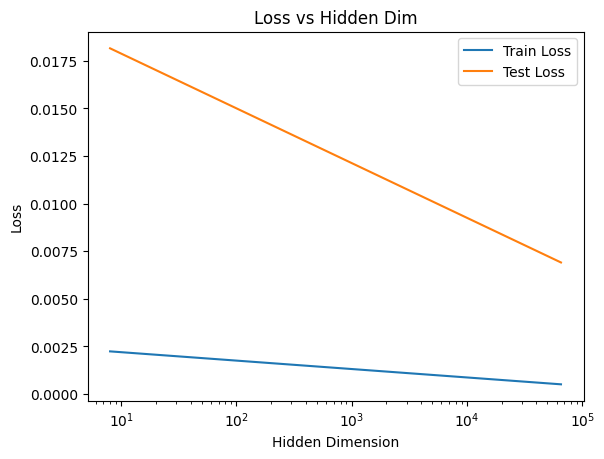

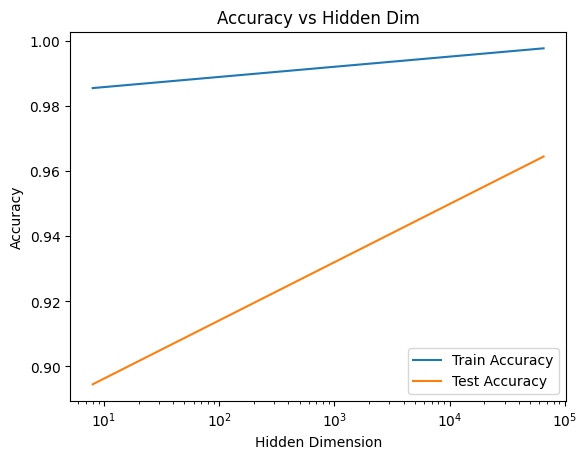

In [ ]:

# This is the actual training loop! Even though this is not code you will need
# to write, you should definitely read this! It's good to understand exactly how
# our model is being trained!
#
# You might notice that we're using MSELoss instead of cross-entropy loss. It
# turns out that this is enough to get quite reasonable models and considerably
# simplifies some of the presentataion to people who have only an introductory
# understanding of neural nets.

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for model in models:
    print(f"Processing hidden_dim {model.hidden_dim}")
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    # Training
    train_loss = 0
    train_accuracy = 0
    train_samples = 0
    if TRAIN_FROM_SCRATCH:
      model = model.to(DEVICE)
      for epoch in range(EPOCHS):
          if LOAD_EVERYTHING_INTO_GPU_MEMORY:
              # Re-shuffle the train loader
              train_loader = generate_simple_loader(train_dataset, BATCH_SIZE)
          for batch_idx, (data, target) in enumerate(train_loader):
              optimizer.zero_grad()
              output = model(data)
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()
    else:
      model.load_state_dict(torch.load(f"mnist_model_hidden_layer_{model.hidden_dim}"))
      model = model.to(DEVICE)
    with torch.no_grad():
      for data, target in train_loader:
          output = model(data)
          train_loss += criterion(output, target).item()
          train_accuracy += (output.argmax(dim=1) == target.argmax(dim=1)).sum().item()
          train_samples += data.shape[0]
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy / train_samples)

    # Testing
    test_loss = 0
    test_accuracy = 0
    test_samples = 0
    with torch.no_grad():
        for test_data, test_target in test_loader:
            output = model(test_data)
            loss = criterion(output, test_target)
            test_loss += loss.item()
            test_accuracy += (output.argmax(dim=1) == test_target.argmax(dim=1)).sum().item()
            test_samples += test_data.shape[0]
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy / test_samples)

plt.plot(hidden_dims, train_losses, label='Train Loss')
plt.plot(hidden_dims, test_losses, label='Test Loss')
plt.xlabel('Hidden Dimension')
plt.ylabel('Loss')
plt.title('Loss vs Hidden Dim')
plt.xscale("log")
plt.legend()
plt.show()

plt.plot(hidden_dims, train_accuracies, label='Train Accuracy')
plt.plot(hidden_dims, test_accuracies, label='Test Accuracy')
plt.xlabel('Hidden Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hidden Dim')
plt.xscale("log")
plt.legend()
plt.show()

In [ ]:

if TRAIN_FROM_SCRATCH:
  for dim, model in zip(hidden_dims, models):
    # Save on CPU because this makes it easier to load for more devices
    model = model.to("cpu")
    torch.save(model.state_dict(), f"mnist_model_hidden_layer_{dim}")

In [ ]:

# Go ahead and run this just to make sure

for model in models:
  model = model.to(DEVICE)

In [ ]:

# Fill this out! This should calculate the accuracy of the model for each digit.

def accuracy_by_digit(model, loader):
  # TODO: Implement this!
  #raise NotImplementedError()
  correct = [0] * 10
  total = [0] * 10
  with torch.no_grad():
    for data, target_probs in loader:
      output_probs = model(data)
      output = output_probs.argmax(dim=1)
      target = target_probs.argmax(dim=1)
      for i in range(target.shape[0]):
        total[target[i]] += 1
        if output[i] == target[i]:
          correct[target[i]] += 1
  return [correct[i] / total[i] for i in range(10)]

In [ ]:

# This is all a lot of visualization code which you can either read or just run.

#plots the image
def visualize_image(image):
  plt.imshow(image.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.show()

#plots the heatmap of a key
def visualize_ith_key(model, i):
  key = pull_out_ith_key(model, i).reshape(28, 28)
  key_bias = model.fc1.bias[i]
  plt.imshow(key.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.title(f'Key {i} (bias: {key_bias})')
  plt.show()

#plots a heatmap of a value
def visualize_ith_value(model, i):
  value = pull_out_ith_value(model, i).unsqueeze(0)
  plt.imshow(value.detach().numpy(), cmap='viridis')
  for x in range(value.shape[1]):
    plt.text(x, 0, f'{value[0, x].item():.3f}', ha='center', va='center', color='red', fontsize=6)
  plt.axis('off')
  plt.title(f'Value {i}')
  plt.show()

#visualizes the global value bias for each digit, or the baseline before any interactions
def visualize_value_bias(model):
  value = model.fc2.bias.unsqueeze(0)
  plt.imshow(value.detach().numpy(), cmap='viridis')
  for x in range(value.shape[1]):
    plt.text(x, 0, f'{value[0, x].item():.3f}', ha='center', va='center', color='red', fontsize=6)
  plt.axis('off')
  plt.title(f'Global value bias')
  plt.show()

#combines the above 3 visualization functions
def visualize_ith_key_value(model, i):
  visualize_ith_key(model, i)
  visualize_ith_value(model, i)
  visualize_value_bias(model)

#Shows most influential interaction areas between an image and key
def visualize_element_wise_multi_of_key_image(model, i, image):
  key = model.fc1.weight[i].reshape(28, 28)
  element_wise_multi = key * image
  plt.imshow(element_wise_multi.detach().numpy(), cmap='viridis')
  plt.axis('off')
  plt.title(f'Element-wise multiplication of key {i} with image')
  plt.show()
  print(f"Dot-Product: {torch.sum(element_wise_multi)}")

#combines all of the above visualization functions
def visualize_ith_key_value_on_image(model, i, image):
  visualize_ith_key_value(model, i)
  visualize_element_wise_multi_of_key_image(model, i, image)


In [ ]:

import copy

def delete_by_index(x: torch.Tensor, indices, dim: int = 0):
    """
    Return a new tensor with the specified indices removed along `dim`.

    Args
    ----
    x (torch.Tensor): input tensor
    indices (Sequence[int] | torch.Tensor): positions to delete
    dim (int): dimension along which to delete (default 0)

    Example
    -------
    >>> t = torch.tensor([[10, 11],
    ...                   [20, 21],
    ...                   [30, 31],
    ...                   [40, 41]])
    >>> delete_by_index(t, [1, 3])
    tensor([[10, 11],
            [30, 31]])
    """
    # Ensure we have a 1-D LongTensor of unique, sorted indices on the same device
    idx = torch.as_tensor(indices, dtype=torch.long, device=x.device).unique().sort().values

    # Build a boolean mask that is False at the indices we want to drop
    mask_shape = [1] * x.dim()
    mask_shape[dim] = x.size(dim)
    mask = torch.ones(mask_shape, dtype=torch.bool, device=x.device).squeeze()
    mask[idx] = False

    return x[mask] if dim == 0 else x.transpose(0, dim)[mask].transpose(0, dim)

#removes a certain key from the model
def knock_out_ith_key(model: SimpleNN, key_value_idx: torch.Tensor) -> SimpleNN:
  with torch.no_grad():
    new_model = copy.deepcopy(model)
    new_model.fc1 = torch.nn.Linear(model.fc1.in_features, model.fc1.out_features - key_value_idx.shape[0])
    new_model.fc2 = torch.nn.Linear(model.fc2.in_features - key_value_idx.shape[0], model.fc2.out_features)
    new_model.fc1.weight = torch.nn.Parameter(delete_by_index(model.fc1.weight, key_value_idx))
    new_model.fc1.bias = torch.nn.Parameter(delete_by_index(model.fc1.bias, key_value_idx))
    new_model.fc2.weight = torch.nn.Parameter(delete_by_index(model.fc2.weight, key_value_idx, dim=1))
    return new_model

In [ ]:
#
#
#
# new test stuff
#
#
#

In [ ]:

#finds key-value pairs where the value is small for every digit
def find_mostly_zero_values(model, threshold=0.05):
  return torch.tensor([idx for idx in range(model.fc2.weight.shape[1]) if (torch.abs(model.fc2.weight[:, idx]) < threshold).all()])

In [ ]:

#finds the key-value pairs where the values for each digit are mostly similar to each other
def find_mostly_similar_values(model, threshold=0.05):
    possible_idx = []

    for idx in range(model.fc2.weight.shape[1]):
      if (torch.max(model.fc2.weight[:, idx]) - torch.min(model.fc2.weight[:, idx]) < threshold):
        possible_idx.append(idx)

    return torch.tensor(possible_idx)

In [ ]:
#function to find keys close to 0
def find_mostly_zero_keys(model, threshold=0.05):
  return torch.tensor([idx for idx in range(model.fc1.weight.shape[0]) if (torch.abs(model.fc1.weight[idx, :]) < threshold).all()])

In [ ]:
#function compiling all knockout (pruning) functions for key-value pairs
def take_out_all_from_model(model, values_zero_threshold=0.00, values_similar_threshold=0.00, keys_zero_threshold=0.00):
  values_close_to_zero = find_mostly_zero_values(model, threshold=values_zero_threshold)
  new_model = knock_out_ith_key(model, values_close_to_zero)
  values_that_are_mostly_similar = find_mostly_similar_values(new_model, threshold=values_similar_threshold)
  new_model = knock_out_ith_key(new_model, values_that_are_mostly_similar)
  keys_close_to_zero = find_mostly_zero_keys(new_model, threshold=keys_zero_threshold)
  return knock_out_ith_key(new_model, keys_close_to_zero)

In [ ]:
#version that prints out some keys, I should make a function that finds the smallest ones and prints out those
def take_out_all_from_model_test_ver(model, values_zero_threshold=0.00, values_similar_threshold=0.00, keys_zero_threshold=0.00):
  values_close_to_zero = find_mostly_zero_values(model, threshold=values_zero_threshold)
  new_model = knock_out_ith_key(model, values_close_to_zero)
  values_that_are_mostly_similar = find_mostly_similar_values(new_model, threshold=values_similar_threshold)
  new_model = knock_out_ith_key(new_model, values_that_are_mostly_similar)
  keys_close_to_zero = find_mostly_zero_keys(new_model, threshold=keys_zero_threshold)
  print(keys_close_to_zero)
  return knock_out_ith_key(new_model, keys_close_to_zero)

In [ ]:
original_model = take_out_all_from_model_test_ver(models[1], values_zero_threshold=0.0, values_similar_threshold=0.0, keys_zero_threshold=0.0)

tensor([])


In [ ]:
pruned_model = take_out_all_from_model_test_ver(models[1], values_zero_threshold=0.05, values_similar_threshold=0.05, keys_zero_threshold=0.00)

tensor([])


In [ ]:
print(accuracy_by_digit(pruned_model.to(DEVICE), test_loader))

[0.9857142857142858, 0.9823788546255506, 0.9641472868217055, 0.9623762376237623, 0.9439918533604889, 0.929372197309417, 0.975991649269311, 0.958171206225681, 0.9743326488706365, 0.9623389494549058]


In [ ]:
print(pruned_model.fc2.weight.shape)

torch.Size([10, 22177])


In [ ]:
#Using L2 norm between probability vectors
def get_and_viz_img_with_biggest_change(model1, model2, loader, top_k=5):

    images, targets_one_hot = next(iter(loader))
    labels = targets_one_hot.argmax(dim=1)

    with torch.no_grad():
        probs1 = model1(images)
        probs2 = model2(images)

        prob_diff = probs2 - probs1

        change_magnitudes = torch.linalg.norm(prob_diff, ord=2, dim=1)

        sorted_magnitudes, sorted_indices = torch.sort(change_magnitudes, descending=True)

        print(f"Top {top_k} test images with the largest probability change between models:")
        print(f"Indices: \n")
        print(sorted_indices[:top_k])
        print(f"Magnitudes: \n")
        print(sorted_magnitudes[:top_k])

        for i in range(top_k):
            img_idx = sorted_indices[i].item()

            image = images[img_idx].cpu().squeeze()
            label = labels[img_idx].item()
            p1 = probs1[img_idx].cpu()
            p2 = probs2[img_idx].cpu()
            pred1 = p1.argmax().item()
            pred2 = p2.argmax().item()
            magnitude = sorted_magnitudes[i].item()

            print(f"\n--- Rank {i+1} (Image Index in test set: {img_idx}) ---")
            print(f"Magnitude of Change (L2 Norm): {magnitude:.4f}")
            print(f"Actual Label: {label}")
            print(f"Original model (dim={model1.fc2.weight.shape}) Prediction: {pred1} (Correct: {pred1 == label})")
            print(f"Pruned Model (dim={model2.fc2.weight.shape}) Prediction: {pred2} (Correct: {pred2 == label})")
            print(f"Original model probs: {p1}")
            print(f"Pruned model probs: {p2}")


            visualize_image(image)


            fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
            digits = np.arange(10)

            ax[0].bar(digits, p1.numpy(), color='cornflowerblue')
            ax[0].set_title(f"Original model (dim={model1.fc2.weight.shape}) Probs")
            ax[0].set_xticks(digits)
            ax[0].set_xlabel("Digit")
            ax[0].set_ylabel("Probability")
            ax[0].set_ylim(0, 1)

            ax[1].bar(digits, p2.numpy(), color='salmon')
            ax[1].set_title(f"Pruned Model (dim={model2.fc2.weight.shape}) Probs")
            ax[1].set_xticks(digits)
            ax[1].set_xlabel("Digit")
            ax[1].set_ylim(0, 1)

            fig.suptitle(f"Prediction comparison for a '{label}'", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()




In [ ]:
def plot_dot_products(dot_products):

    plt.figure(figsize=(10, 6))
    plt.hist(dot_products.numpy(), bins=50, edgecolor='black')
    plt.xlabel('Dot Product Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [ ]:
def combined_dot_product_dist(model, loader, i):
  dot_products = return_dot_products(model, loader, i)
  plot_dot_products(torch.tensor(dot_products))

In [ ]:
def return_dot_products(model, loader, i):
    images, _ = next(iter(loader))

    img = images[i]
    viz_img = images[i].cpu().squeeze()
    visualize_image(viz_img)
    dot_products = []

    with torch.no_grad():
        for i in range(model.fc1.weight.shape[0]):
            key = model.fc1.weight[i].reshape(28, 28)
            element_wise_multi = key * img
            dot = torch.sum(element_wise_multi)
            dot_products.append(dot.item())

    return dot_products


In [ ]:
def plot_dot_products_side_by_side(dot_products1, dot_products2, model1, model2):
    """
    Plot two dot product distributions side by side with model dimensions and counts on bars
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

    if isinstance(dot_products1, torch.Tensor):
        dot_products1 = dot_products1.numpy()
    if isinstance(dot_products2, torch.Tensor):
        dot_products2 = dot_products2.numpy()

    stats1 = {
        'mean': np.mean(dot_products1),
        'std': np.std(dot_products1),
        'median': np.median(dot_products1),
        'min': np.min(dot_products1),
        'max': np.max(dot_products1),
        'range': np.max(dot_products1) - np.min(dot_products1),
        'q25': np.percentile(dot_products1, 25),
        'q75': np.percentile(dot_products1, 75),
        'iqr': np.percentile(dot_products1, 75) - np.percentile(dot_products1, 25)
    }

    stats2 = {
        'mean': np.mean(dot_products2),
        'std': np.std(dot_products2),
        'median': np.median(dot_products2),
        'min': np.min(dot_products2),
        'max': np.max(dot_products2),
        'range': np.max(dot_products2) - np.min(dot_products2),
        'q25': np.percentile(dot_products2, 25),
        'q75': np.percentile(dot_products2, 75),
        'iqr': np.percentile(dot_products2, 75) - np.percentile(dot_products2, 25)
    }

    counts1, bins1, patches1 = ax[0].hist(dot_products1, bins=25, edgecolor='black',
                                          color='cornflowerblue', alpha=0.7)
    ax[0].set_title(f"Original model (dim={model1.fc2.weight.shape}) Dot Products")
    ax[0].set_xlabel('Dot Product Value')
    ax[0].set_ylabel('Frequency')
    ax[0].grid(True, alpha=0.3)

    for i, count in enumerate(counts1):
        if count > 0:
            ax[0].text(bins1[i] + (bins1[i+1] - bins1[i])/2, count + max(counts1)*0.01,
                      f'{int(count)}', ha='center', va='bottom', fontsize=8)

    counts2, bins2, patches2 = ax[1].hist(dot_products2, bins=25, edgecolor='black',
                                          color='salmon', alpha=0.7)
    ax[1].set_title(f"Pruned Model (dim={model2.fc2.weight.shape}) Dot Products")
    ax[1].set_xlabel('Dot Product Value')
    ax[1].grid(True, alpha=0.3)

    for i, count in enumerate(counts2):
        if count > 0:
            ax[1].text(bins2[i] + (bins2[i+1] - bins2[i])/2, count + max(counts2)*0.01,
                      f'{int(count)}', ha='center', va='bottom', fontsize=8)

    stats_text1 = f"""Statistics:
Mean: {stats1['mean']:.3f}
Std: {stats1['std']:.3f}
Median: {stats1['median']:.3f}
Min: {stats1['min']:.3f}
Max: {stats1['max']:.3f}
Range: {stats1['range']:.3f}
Q25: {stats1['q25']:.3f}
Q75: {stats1['q75']:.3f}
IQR: {stats1['iqr']:.3f}"""

    stats_text2 = f"""Statistics:
Mean: {stats2['mean']:.3f}
Std: {stats2['std']:.3f}
Median: {stats2['median']:.3f}
Min: {stats2['min']:.3f}
Max: {stats2['max']:.3f}
Range: {stats2['range']:.3f}
Q25: {stats2['q25']:.3f}
Q75: {stats2['q75']:.3f}
IQR: {stats2['iqr']:.3f}"""

    ax[0].text(0.02, -0.25, stats_text1, transform=ax[0].transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

    ax[1].text(0.02, -0.25, stats_text2, transform=ax[1].transAxes, fontsize=9,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()

In [ ]:
def get_and_viz_img_and_dot_with_biggest_change(model1, model2, loader, top_k=5):
    images, targets_one_hot = next(iter(loader))
    labels = targets_one_hot.argmax(dim=1)

    with torch.no_grad():
        probs1 = model1(images)
        probs2 = model2(images)

        prob_diff = probs2 - probs1

        change_magnitudes = torch.linalg.norm(prob_diff, ord=2, dim=1)

        sorted_magnitudes, sorted_indices = torch.sort(change_magnitudes, descending=True)

        print(f"Top {top_k} test images with the largest probability change between models:")
        print(f"Indices: \n")
        print(sorted_indices[:top_k])
        print(f"Magnitudes: \n")
        print(sorted_magnitudes[:top_k])

        for i in range(top_k):
            img_idx = sorted_indices[i].item()

            dot_products_og = []
            dot_products_new = []

            for k in range(model1.fc1.weight.shape[0]):
                key = model1.fc1.weight[k].reshape(28, 28)
                element_wise_multi = key * images[img_idx]
                dot = torch.sum(element_wise_multi)
                dot_products_og.append(dot.item())

            for j in range(model2.fc1.weight.shape[0]):
                key = model2.fc1.weight[j].reshape(28, 28)
                element_wise_multi = key * images[img_idx]
                dot = torch.sum(element_wise_multi)
                dot_products_new.append(dot.item())

            image = images[img_idx].cpu().squeeze()
            label = labels[img_idx].item()
            p1 = probs1[img_idx].cpu()
            p2 = probs2[img_idx].cpu()
            pred1 = p1.argmax().item()
            pred2 = p2.argmax().item()
            magnitude = sorted_magnitudes[i].item()

            print(f"\n--- Rank {i+1} (Image Index in test set: {img_idx}) ---")
            print(f"Magnitude of Change (L2 Norm): {magnitude:.4f}")
            print(f"Actual Label: {label}")
            print(f"Original model (dim={model1.fc2.weight.shape}) Prediction: {pred1} (Correct: {pred1 == label})")
            print(f"Pruned Model (dim={model2.fc2.weight.shape}) Prediction: {pred2} (Correct: {pred2 == label})")
            print(f"Original model probs: {p1}")
            print(f"Pruned model probs: {p2}")

            visualize_image(image)

            print("Dot product distributions comparison:")
            plot_dot_products_side_by_side(dot_products_og, dot_products_new, model1, model2)

            fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
            digits = np.arange(10)

            ax[0].bar(digits, p1.numpy(), color='cornflowerblue')
            ax[0].set_title(f"Original model (dim={model1.fc2.weight.shape}) Probs")
            ax[0].set_xticks(digits)
            ax[0].set_xlabel("Digit")
            ax[0].set_ylabel("Probability")
            ax[0].set_ylim(0, 1)

            ax[1].bar(digits, p2.numpy(), color='salmon')
            ax[1].set_title(f"Pruned Model (dim={model2.fc2.weight.shape}) Probs")
            ax[1].set_xticks(digits)
            ax[1].set_xlabel("Digit")
            ax[1].set_ylim(0, 1)

            fig.suptitle(f"Prediction comparison for a '{label}'", fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

In [ ]:
def analyze_all_images_dot_products(model1, model2, loader, max_images=1000):
    """
    Comprehensive analysis of dot product distributions across all images
    """
    images, targets_one_hot = next(iter(loader))
    labels = targets_one_hot.argmax(dim=1)

    num_images = min(len(images), max_images)
    images = images[:num_images]
    labels = labels[:num_images]

    print(f"Analyzing {num_images} images...")

    all_dot_products_og = []
    all_dot_products_new = []

    means_og = []
    stds_og = []
    skews_og = []
    kurts_og = []

    means_new = []
    stds_new = []
    skews_new = []
    kurts_new = []

    with torch.no_grad():
        for img_idx in range(num_images):
            if img_idx % 100 == 0:
                print(f"Processing image {img_idx}/{num_images}")

            dot_products_og = []
            for k in range(model1.fc1.weight.shape[0]):
                key = model1.fc1.weight[k].reshape(28, 28)
                element_wise_multi = key * images[img_idx]
                dot = torch.sum(element_wise_multi)
                dot_products_og.append(dot.item())

            dot_products_new = []
            for j in range(model2.fc1.weight.shape[0]):
                key = model2.fc1.weight[j].reshape(28, 28)
                element_wise_multi = key * images[img_idx]
                dot = torch.sum(element_wise_multi)
                dot_products_new.append(dot.item())

            all_dot_products_og.append(dot_products_og)
            all_dot_products_new.append(dot_products_new)

            dot_array_og = np.array(dot_products_og)
            dot_array_new = np.array(dot_products_new)

            means_og.append(np.mean(dot_array_og))
            stds_og.append(np.std(dot_array_og))
            skews_og.append(stats.skew(dot_array_og))
            kurts_og.append(stats.kurtosis(dot_array_og))

            means_new.append(np.mean(dot_array_new))
            stds_new.append(np.std(dot_array_new))
            skews_new.append(stats.skew(dot_array_new))
            kurts_new.append(stats.kurtosis(dot_array_new))

    return {
        'all_dot_products_og': all_dot_products_og,
        'all_dot_products_new': all_dot_products_new,
        'means_og': means_og,
        'stds_og': stds_og,
        'skews_og': skews_og,
        'kurts_og': kurts_og,
        'means_new': means_new,
        'stds_new': stds_new,
        'skews_new': skews_new,
        'kurts_new': kurts_new,
        'images': images,
        'labels': labels
    }

In [ ]:
def plot_3d_histogram_surface(results, sort_by_mean=True, num_bins=20, max_images_3d=1000):
    """
    Create 3D histogram surface showing distribution shapes across images
    """
    num_images = len(results['all_dot_products_new'])

    if sort_by_mean:
        sort_indices = np.argsort(results['means_new'])
        print("Sorting images by mean dot product value for smoother visualization...")
    else:
        sort_indices = np.arange(num_images)

    sample_size = min(max_images_3d, num_images)
    sample_indices = sort_indices[::max(1, num_images//sample_size)][:sample_size]

    all_dots_new = np.concatenate([results['all_dot_products_new'][i] for i in sample_indices])
    all_dots_og = np.concatenate([results['all_dot_products_og'][i] for i in sample_indices])

    min_val = min(np.min(all_dots_new), np.min(all_dots_og))
    max_val = max(np.max(all_dots_new), np.max(all_dots_og))
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    fig = plt.figure(figsize=(20, 12))

    ax1 = fig.add_subplot(221, projection='3d')

    X_og, Y_og, Z_og = [], [], []
    for i, img_idx in enumerate(sample_indices):
        dot_products = results['all_dot_products_og'][img_idx]
        hist_counts, _ = np.histogram(dot_products, bins=bin_edges, density=True)

        for j, count in enumerate(hist_counts):
            if count > 0:
                X_og.append(i)
                Y_og.append(bin_centers[j])
                Z_og.append(count)

    scatter1 = ax1.scatter(X_og, Y_og, Z_og, c=Z_og, cmap='viridis', alpha=0.7, s=20)
    ax1.set_xlabel('Image Index (sorted by mean)')
    ax1.set_ylabel('Dot Product Value')
    ax1.set_zlabel('Density')
    ax1.set_title(f'3D Histogram Surface - Original Model\n(dim={results["all_dot_products_og"][0].__len__()})')

    ax2 = fig.add_subplot(222, projection='3d')

    X_new, Y_new, Z_new = [], [], []
    for i, img_idx in enumerate(sample_indices):
        dot_products = results['all_dot_products_new'][img_idx]
        hist_counts, _ = np.histogram(dot_products, bins=bin_edges, density=True)

        for j, count in enumerate(hist_counts):
            if count > 0:
                X_new.append(i)
                Y_new.append(bin_centers[j])
                Z_new.append(count)

    scatter2 = ax2.scatter(X_new, Y_new, Z_new, c=Z_new, cmap='plasma', alpha=0.7, s=20)
    ax2.set_xlabel('Image Index (sorted by mean)')
    ax2.set_ylabel('Dot Product Value')
    ax2.set_zlabel('Density')
    ax2.set_title(f'3D Histogram Surface - Pruned Model\n(dim={results["all_dot_products_new"][0].__len__()})')

    ax3 = fig.add_subplot(223)
    sorted_skews_og = [results['skews_og'][i] for i in sample_indices]
    sorted_skews_new = [results['skews_new'][i] for i in sample_indices]

    ax3.plot(sorted_skews_og, label='Original Model', color='blue', alpha=0.7, linewidth=2, marker='o', markersize=3)
    ax3.plot(sorted_skews_new, label='Pruned Model', color='red', alpha=0.7, linewidth=2, marker='s', markersize=3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No Skew')
    ax3.set_xlabel('Image Index (sorted by mean)')
    ax3.set_ylabel('Skewness')
    ax3.set_title('Skewness Evolution Across Sorted Images')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(224)

    representative_indices = [0, len(sample_indices)//4, len(sample_indices)//2, 3*len(sample_indices)//4, -1]
    colors = plt.cm.Set1(np.linspace(0, 1, len(representative_indices)))

    for i, rep_idx in enumerate(representative_indices):
        if rep_idx >= len(sample_indices):
            continue
        img_idx = sample_indices[rep_idx]

        ax4.hist(results['all_dot_products_og'][img_idx], bins=bin_edges, alpha=0.3,
                color=colors[i], density=True, label=f'Orig {img_idx}')
        ax4.hist(results['all_dot_products_new'][img_idx], bins=bin_edges, alpha=0.6,
                color=colors[i], density=True, linestyle='--', histtype='step', linewidth=2,
                label=f'Pruned {img_idx}')

    ax4.set_xlabel('Dot Product Value')
    ax4.set_ylabel('Density')
    ax4.set_title('Sample Individual Histograms\n(Solid=Original, Dashed=Pruned)')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#comparisons
def plot_distribution_comparison(results, model1, model2):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    axes[0,0].scatter(results['skews_og'], results['skews_new'], alpha=0.6)
    axes[0,0].plot([-5, 5], [-5, 5], 'r--', alpha=0.5)
    axes[0,0].set_xlabel('Original Model Skewness')
    axes[0,0].set_ylabel('Pruned Model Skewness')
    axes[0,0].set_title('Skewness: Original vs Pruned')
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].scatter(results['stds_og'], results['stds_new'], alpha=0.6)
    axes[0,1].plot([0, max(max(results['stds_og']), max(results['stds_new']))],
                   [0, max(max(results['stds_og']), max(results['stds_new']))], 'r--', alpha=0.5)
    axes[0,1].set_xlabel('Original Model Std Dev')
    axes[0,1].set_ylabel('Pruned Model Std Dev')
    axes[0,1].set_title('Standard Deviation: Original vs Pruned')
    axes[0,1].grid(True, alpha=0.3)

    axes[0,2].scatter(results['means_og'], results['means_new'], alpha=0.6)
    axes[0,2].plot([min(min(results['means_og']), min(results['means_new'])),
                    max(max(results['means_og']), max(results['means_new']))],
                   [min(min(results['means_og']), min(results['means_new'])),
                    max(max(results['means_og']), max(results['means_new']))], 'r--', alpha=0.5)
    axes[0,2].set_xlabel('Original Model Mean')
    axes[0,2].set_ylabel('Pruned Model Mean')
    axes[0,2].set_title('Mean: Original vs Pruned')
    axes[0,2].grid(True, alpha=0.3)

    axes[1,0].hist(results['skews_og'], bins=30, alpha=0.7, label=f'Original (dim={len(results["all_dot_products_og"][0])})', color='cornflowerblue')
    axes[1,0].hist(results['skews_new'], bins=30, alpha=0.7, label=f'Pruned (dim={len(results["all_dot_products_new"][0])})', color='salmon')
    axes[1,0].set_xlabel('Skewness')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Skewness Values')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    axes[1,1].hist(results['stds_og'], bins=30, alpha=0.7, label=f'Original (dim={len(results["all_dot_products_og"][0])})', color='cornflowerblue')
    axes[1,1].hist(results['stds_new'], bins=30, alpha=0.7, label=f'Pruned (dim={len(results["all_dot_products_new"][0])})', color='salmon')
    axes[1,1].set_xlabel('Standard Deviation')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Standard Deviations')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    axes[1,2].scatter(results['means_new'], results['stds_new'], alpha=0.6, color='salmon')

    correlation = np.corrcoef(results['means_new'], results['stds_new'])[0,1]
    axes[1,2].set_xlabel('Mean')
    axes[1,2].set_ylabel('Standard Deviation')
    axes[1,2].set_title(f'Mean vs Std (Pruned Model)\nCorrelation: {correlation:.3f}')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def test_normality(results):
    """
    Test if dot product distributions follow normal distribution - used Claude, need to fix this
    """
    print("=== NORMALITY TESTS ===")

    sample_size = min(1000, len(results['all_dot_products_new']))
    sample_indices = np.random.choice(len(results['all_dot_products_new']), sample_size, replace=False)

    shapiro_pvals_og = []
    shapiro_pvals_new = []
    ks_pvals_og = []
    ks_pvals_new = []

    for img_idx in sample_indices:
        dots_og = np.array(results['all_dot_products_og'][img_idx])
        if len(dots_og) > 3:  #
            _, p_shapiro_og = stats.shapiro(dots_og)
            shapiro_pvals_og.append(p_shapiro_og)

            _, p_ks_og = stats.kstest(dots_og, lambda x: stats.norm.cdf(x, np.mean(dots_og), np.std(dots_og)))
            ks_pvals_og.append(p_ks_og)

        dots_new = np.array(results['all_dot_products_new'][img_idx])
        if len(dots_new) > 3:
            _, p_shapiro_new = stats.shapiro(dots_new)
            shapiro_pvals_new.append(p_shapiro_new)

            _, p_ks_new = stats.kstest(dots_new, lambda x: stats.norm.cdf(x, np.mean(dots_new), np.std(dots_new)))
            ks_pvals_new.append(p_ks_new)

    print(f"Shapiro-Wilk Test Results (α=0.05):")
    print(f"Original Model: {np.mean(np.array(shapiro_pvals_og) > 0.05)*100:.1f}% appear normal")
    print(f"Pruned Model: {np.mean(np.array(shapiro_pvals_new) > 0.05)*100:.1f}% appear normal")

    print(f"\nKolmogorov-Smirnov Test Results (α=0.05):")
    print(f"Original Model: {np.mean(np.array(ks_pvals_og) > 0.05)*100:.1f}% appear normal")
    print(f"Pruned Model: {np.mean(np.array(ks_pvals_new) > 0.05)*100:.1f}% appear normal")

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(shapiro_pvals_og, bins=20, alpha=0.7, label='Original', color='cornflowerblue')
    axes[0].hist(shapiro_pvals_new, bins=20, alpha=0.7, label='Pruned', color='salmon')
    axes[0].axvline(0.05, color='red', linestyle='--', label='α=0.05')
    axes[0].set_xlabel('Shapiro-Wilk p-value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Normality Test p-values')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(ks_pvals_og, bins=20, alpha=0.7, label='Original', color='cornflowerblue')
    axes[1].hist(ks_pvals_new, bins=20, alpha=0.7, label='Pruned', color='salmon')
    axes[1].axvline(0.05, color='red', linestyle='--', label='α=0.05')
    axes[1].set_xlabel('KS Test p-value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of KS Test p-values')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_3d_histogram_bars(results, sort_by_mean=True, num_bins=15, max_images_3d=1000):
    """
    Create true 3D histogram bars showing distribution shapes across images
    """
    num_images = len(results['all_dot_products_new'])

    if sort_by_mean:
        sort_indices = np.argsort(results['means_new'])
        print("Sorting images by mean dot product value for smoother visualization...")
    else:
        sort_indices = np.arange(num_images)

    sample_size = min(max_images_3d, num_images)
    sample_indices = sort_indices[::max(1, num_images//sample_size)][:sample_size]

    all_dots_new = np.concatenate([results['all_dot_products_new'][i] for i in sample_indices])
    min_val, max_val = np.min(all_dots_new), np.max(all_dots_new)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    for i, img_idx in enumerate(sample_indices):
        dot_products = results['all_dot_products_new'][img_idx]
        hist_counts, _ = np.histogram(dot_products, bins=bin_edges, density=True)

        for j, count in enumerate(hist_counts):
            if count > 0.001:
                x = i
                y = bin_centers[j]
                z = 0

                dx = 0.8
                dy = bin_width * 0.8
                dz = count

                skew_val = results['skews_new'][img_idx]
                color = plt.cm.RdYlBu_r((skew_val + 3) / 6)

                ax.bar3d(x, y, z, dx, dy, dz, color=color, alpha=0.7, edgecolor='black', linewidth=0.1)

    ax.set_xlabel('Image Index (sorted by mean)')
    ax.set_ylabel('Dot Product Value')
    ax.set_zlabel('Density')
    ax.set_title('3D Histogram Bars - Pruned Model\n(Color = Skewness: Blue=Low, Red=High)')

    skew_values = [results['skews_new'][i] for i in sample_indices]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=min(skew_values), vmax=max(skew_values)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=20)
    cbar.set_label('Skewness')

    plt.tight_layout()
    plt.show()

def plot_3d_histogram_bars_old(results, sort_by_mean=True, num_bins=15, max_images_3d=1000):
    """
    Create true 3D histogram bars showing distribution shapes across images for ORIGINAL model
    """
    num_images = len(results['all_dot_products_og'])

    if sort_by_mean:
        sort_indices = np.argsort(results['means_og'])
        print("Sorting images by mean dot product value for smoother visualization...")
    else:
        sort_indices = np.arange(num_images)

    sample_size = min(max_images_3d, num_images)
    sample_indices = sort_indices[::max(1, num_images//sample_size)][:sample_size]

    all_dots_og = np.concatenate([results['all_dot_products_og'][i] for i in sample_indices])
    min_val, max_val = np.min(all_dots_og), np.max(all_dots_og)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111, projection='3d')

    for i, img_idx in enumerate(sample_indices):
        dot_products = results['all_dot_products_og'][img_idx]
        hist_counts, _ = np.histogram(dot_products, bins=bin_edges, density=True)

        for j, count in enumerate(hist_counts):
            if count > 0.001:
                x = i
                y = bin_centers[j]
                z = 0

                dx = 0.8
                dy = bin_width * 0.8
                dz = count

                skew_val = results['skews_og'][img_idx]
                color = plt.cm.RdYlBu_r((skew_val + 3) / 6)

                ax.bar3d(x, y, z, dx, dy, dz, color=color, alpha=0.7, edgecolor='black', linewidth=0.1)

    ax.set_xlabel('Image Index (sorted by mean)')
    ax.set_ylabel('Dot Product Value')
    ax.set_zlabel('Density')
    ax.set_title('3D Histogram Bars - ORIGINAL Model\n(Color = Skewness: Blue=Low, Red=High)')

    skew_values = [results['skews_og'][i] for i in sample_indices]
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=min(skew_values), vmax=max(skew_values)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=20)
    cbar.set_label('Skewness')

    plt.tight_layout()
    plt.show()

def run_3d_histogram_analysis(model1, model2, loader, max_images=1000):
    """
    Run comprehensive 3D histogram analysis with normality tests and ReLU analysis
    """
    print("Starting comprehensive 3D histogram analysis...")

    # 1. Calculate dot products for all images
    results = analyze_all_images_dot_products(model1, model2, loader, max_images)

    # 2. Print basic summary
    print(f"\nBasic Statistics:")
    print(f"Original model skewness: mean={np.mean(results['skews_og']):.3f}, std={np.std(results['skews_og']):.3f}")
    print(f"Pruned model skewness: mean={np.mean(results['skews_new']):.3f}, std={np.std(results['skews_new']):.3f}")
    print(f"Original model kurtosis: mean={np.mean(results['kurts_og']):.3f}, std={np.std(results['kurts_og']):.3f}")
    print(f"Pruned model kurtosis: mean={np.mean(results['kurts_new']):.3f}, std={np.std(results['kurts_new']):.3f}")

    # 3. Create 3D histogram surface plots
    plot_3d_histogram_surface(results, sort_by_mean=True, num_bins=20, max_images_3d=50)

    # 4. Create 3D histogram bar plots (pruned model)
    plot_3d_histogram_bars(results, sort_by_mean=True, num_bins=15, max_images_3d=30)

    # 5. Create 3D histogram bar plots (original model)
    plot_3d_histogram_bars_old(results, sort_by_mean=True, num_bins=15, max_images_3d=30)

    # 6. Distribution comparison plots
    plot_distribution_comparison(results, model1, model2)

    # 7. Test normality - this one is broken for now
    test_normality(results)

    return results

Starting comprehensive 3D histogram analysis...
Analyzing 1000 images...
Processing image 0/1000
Processing image 100/1000
Processing image 200/1000
Processing image 300/1000
Processing image 400/1000
Processing image 500/1000
Processing image 600/1000
Processing image 700/1000
Processing image 800/1000
Processing image 900/1000

Basic Statistics:
Original model skewness: mean=-0.994, std=0.196
Pruned model skewness: mean=0.422, std=0.232
Original model kurtosis: mean=2.575, std=0.975
Pruned model kurtosis: mean=1.135, std=0.405
Sorting images by mean dot product value for smoother visualization...


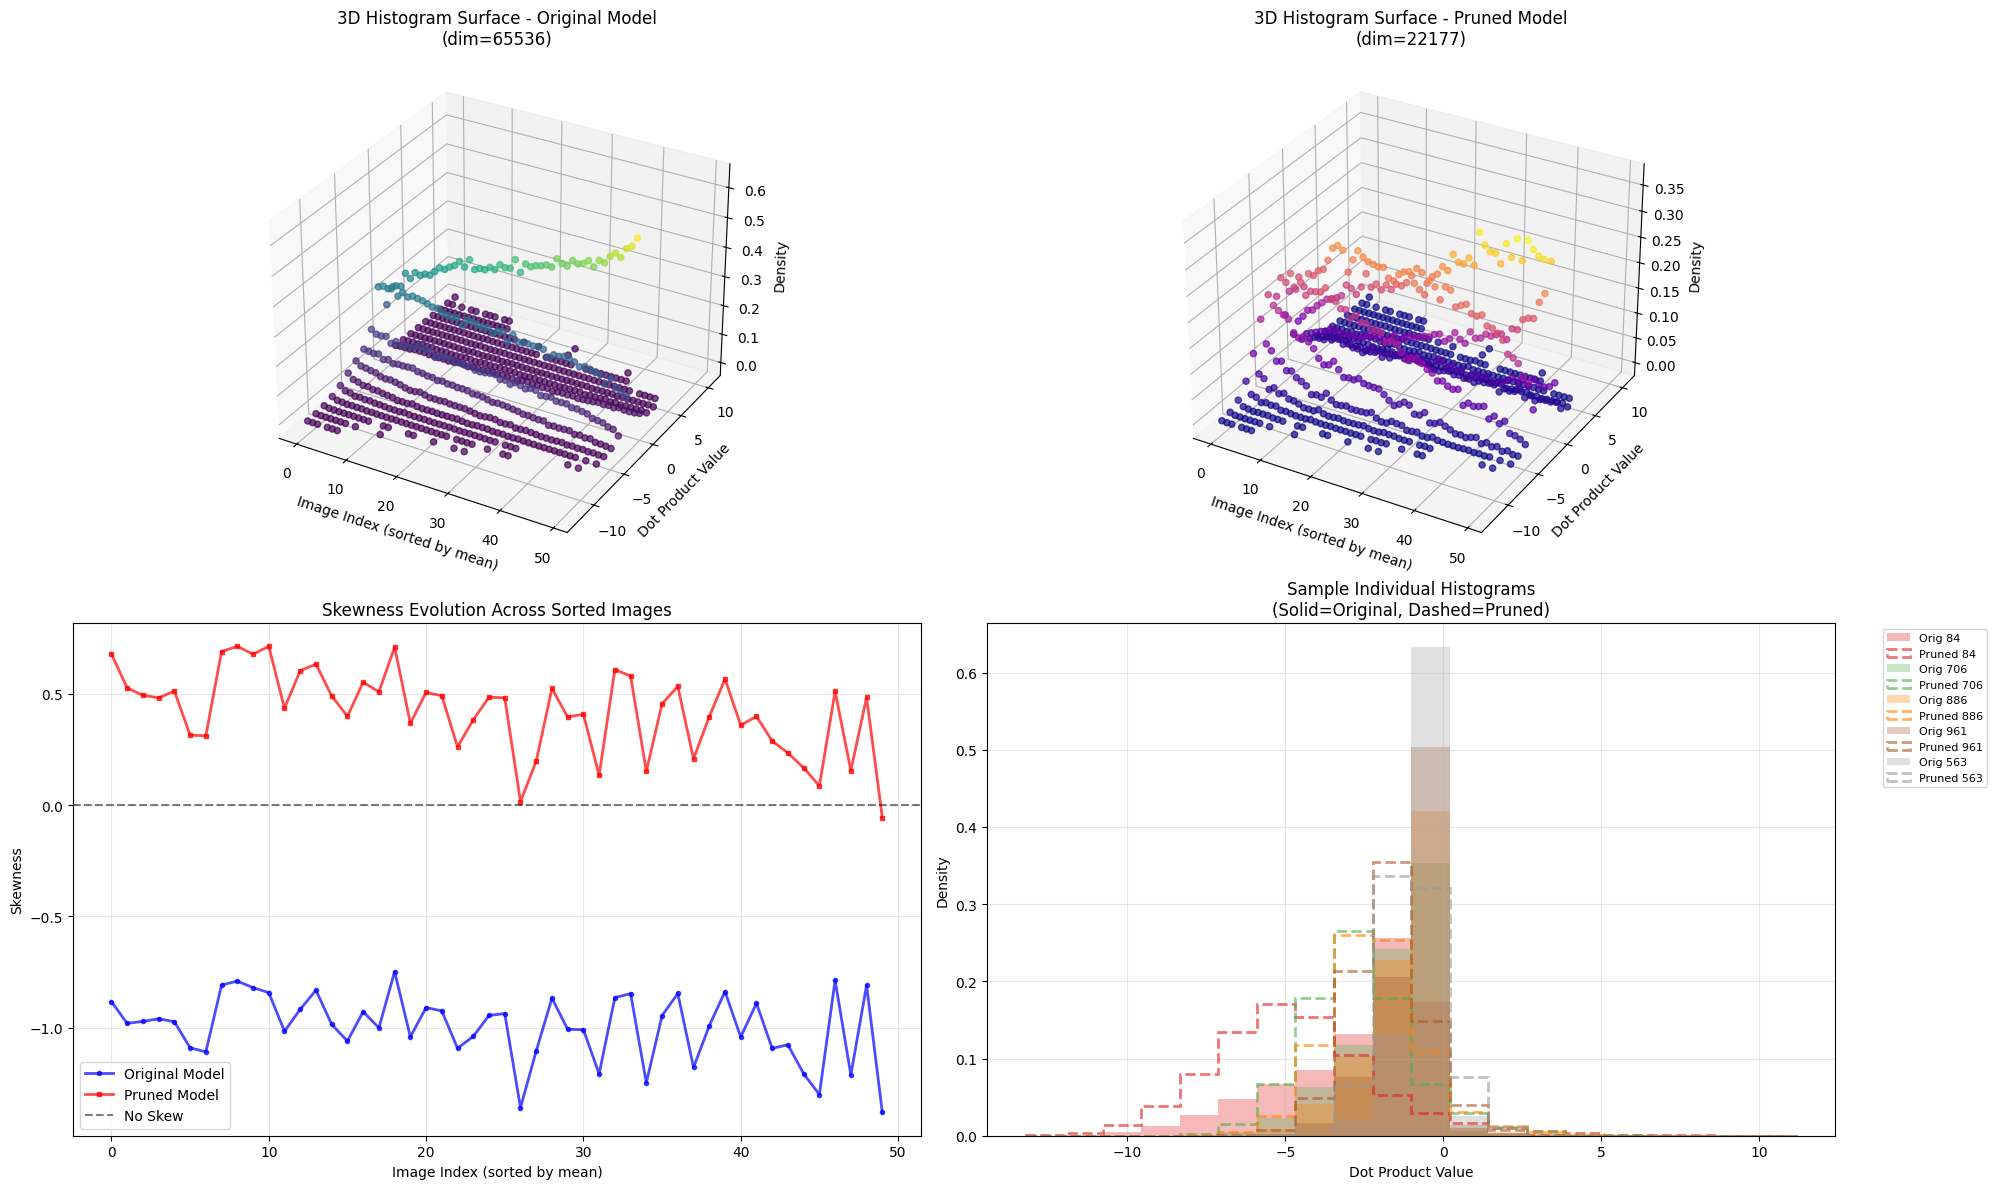

Sorting images by mean dot product value for smoother visualization...


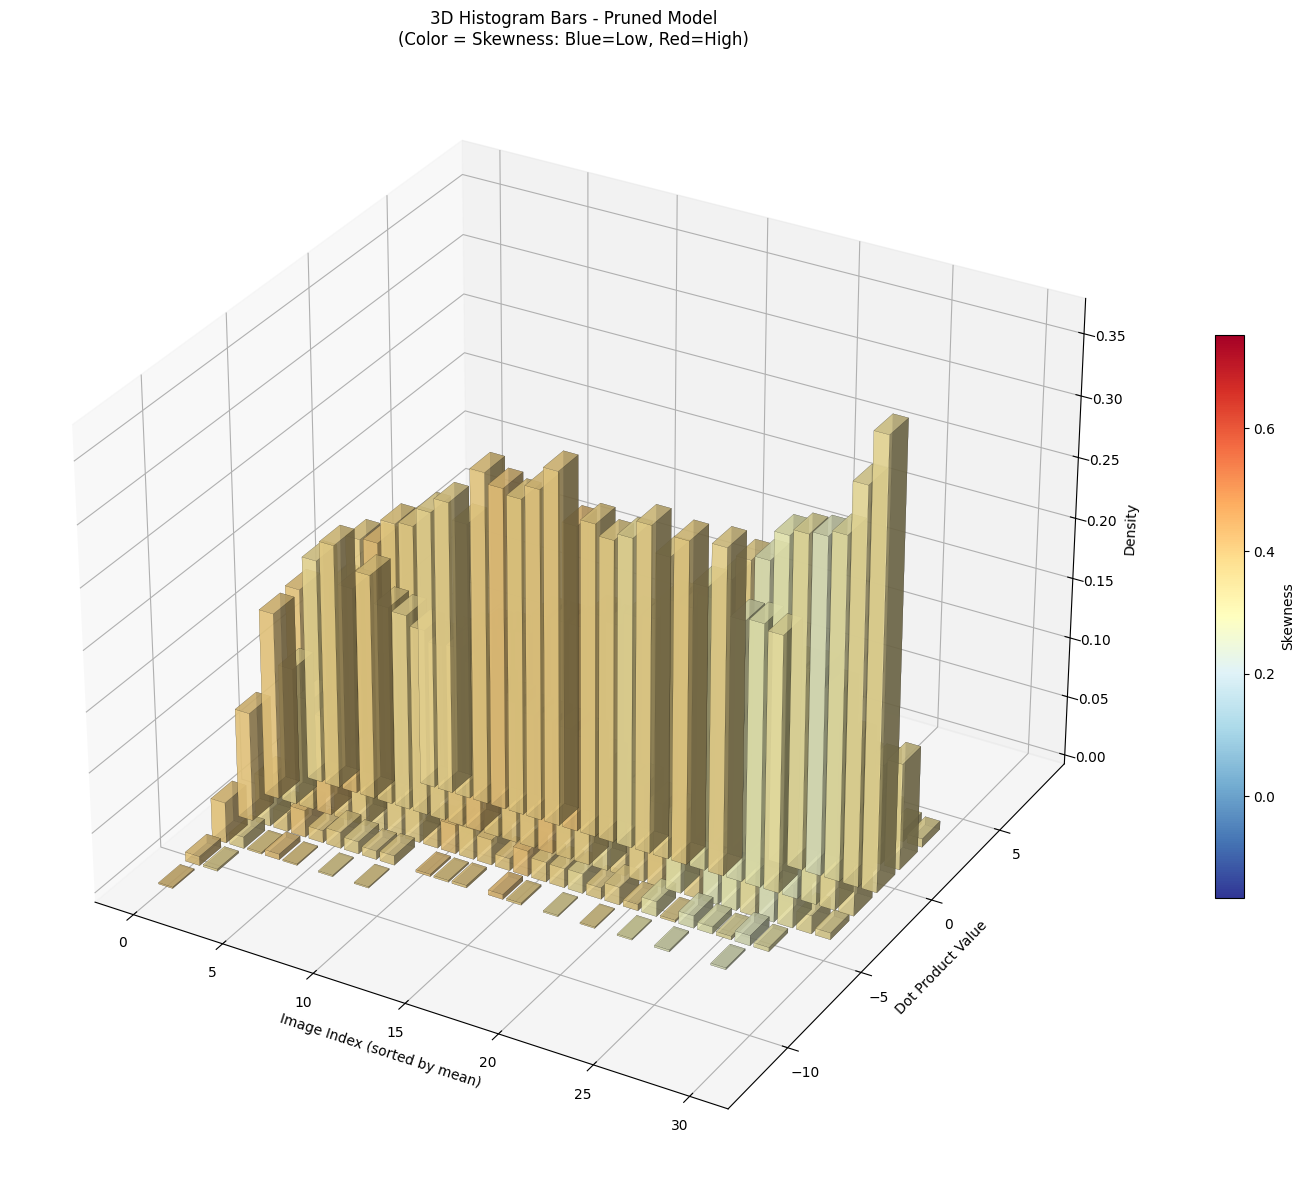

Sorting images by mean dot product value for smoother visualization...


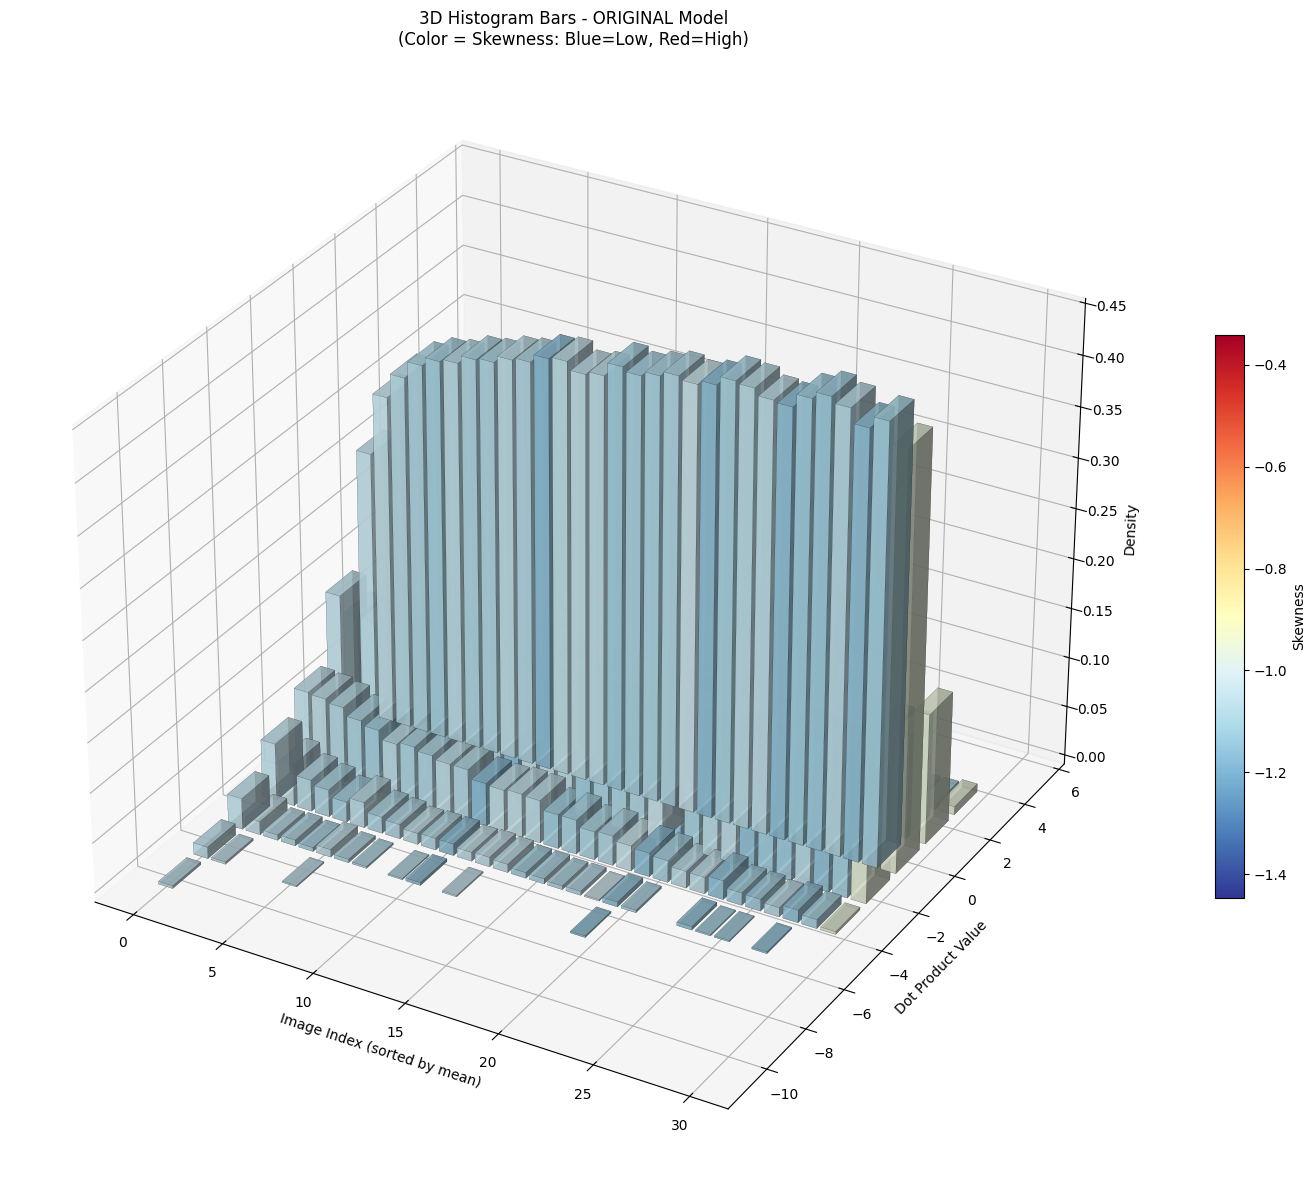

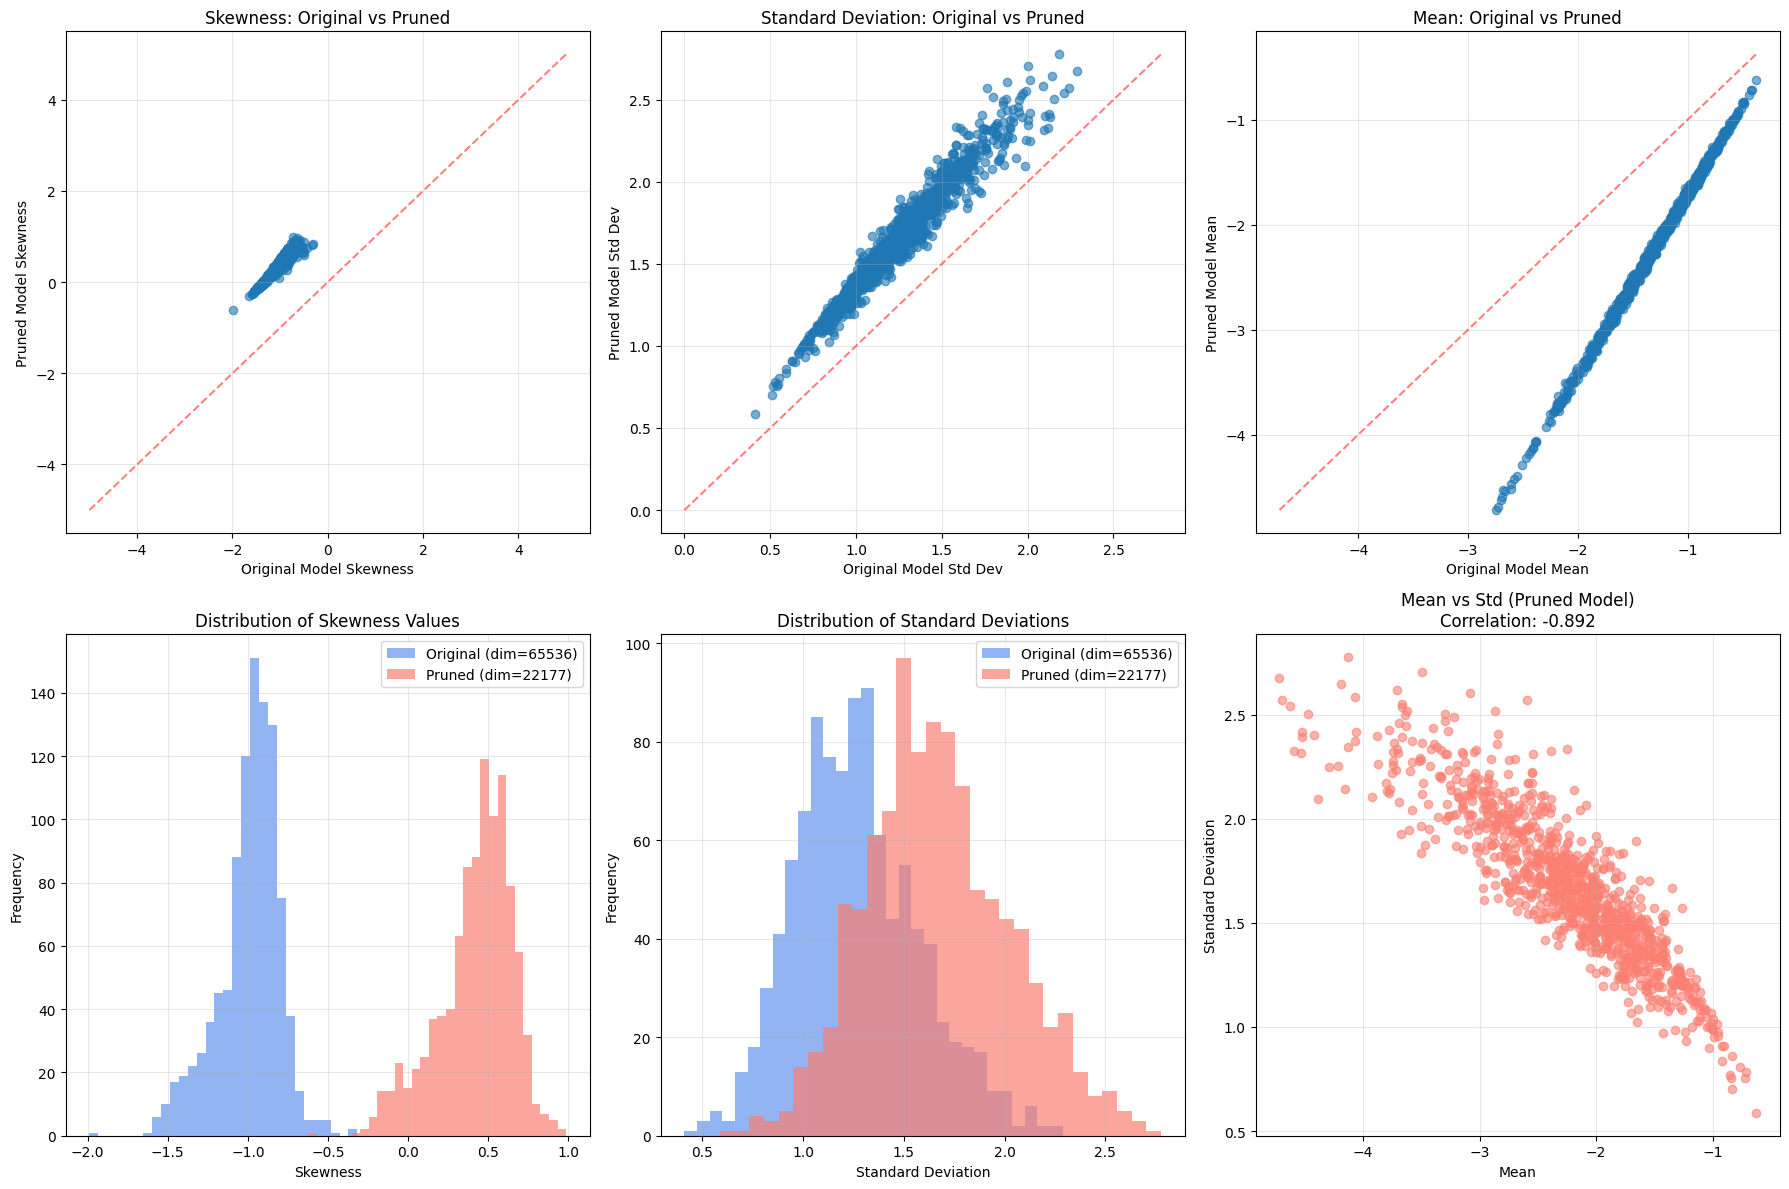

=== NORMALITY TESTS ===


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 65536.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22177.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test Results (α=0.05):
Original Model: 0.0% appear normal
Pruned Model: 0.0% appear normal

Kolmogorov-Smirnov Test Results (α=0.05):
Original Model: 0.0% appear normal
Pruned Model: 0.0% appear normal


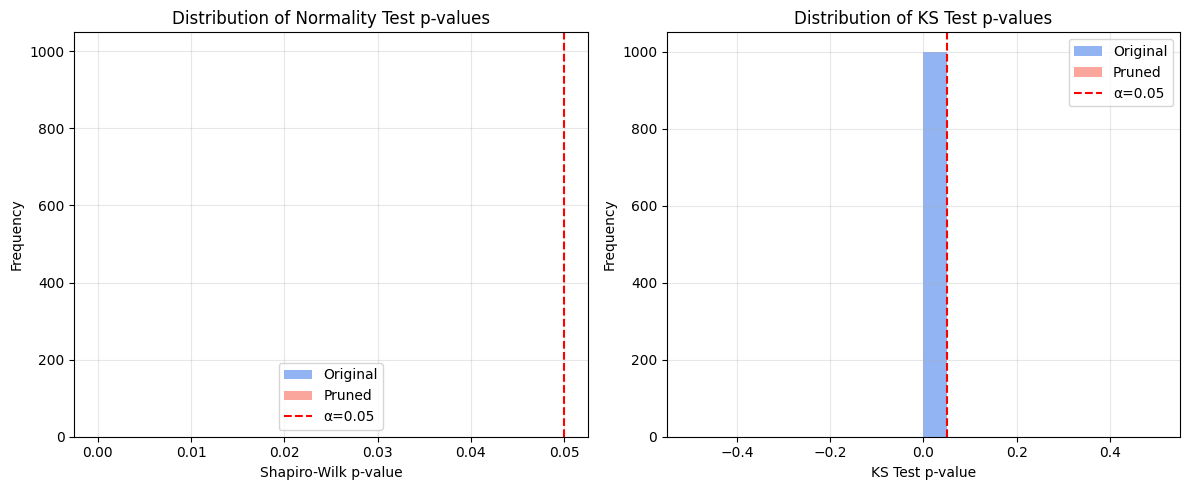

In [ ]:
results = run_3d_histogram_analysis(models[1], pruned_model.to(DEVICE), test_loader, max_images=1000)